## Project Setup

In [5]:
import os
import re
import bs4
import tqdm
import math
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as db
import geopandas as gpd
import scipy.stats as stats
import matplotlib.animation as animation
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [6]:
# global variables
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"
WEATHER_CSV = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv", "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = ""

In [7]:
# load the Taxi Zone Shapefile to get the GEOmetry of each zone
GEO = gpd.read_file(filename='taxi_zones.zip', engine='fiona')
GEO = GEO.to_crs(4326)

# get the coordinates of the pickup and dropoff locations
GEO['longitude'] = GEO.centroid.x
GEO['latitude'] = GEO.centroid.y

# some location IDs are duplicated so those IDs are removed 
GEO.drop_duplicates('LocationID',inplace=True)
GEO.set_index('LocationID',inplace=True)

## Part 1: Data Preprocessing

In Part1, we will preprocess the data. We will do the following steps:

1. Calculate the distance using latitude and longitude.
2. Download the yellow_tripdata_yyyy-mm.parquet from the NYC Taxi & Limousine Commission using `requests` library.
3. Load and clean the yellow taxi data from 2009-01 to 2015-06.
4. Load and clean the uber data.
5. Load and clean the weather data from 2009 to 2015.

### Calculating distance

The most important thing in a trip is the distance, so we need to calculate the distance from the start to the end of the trip. Considering the earth is a sphere, we can use the Haversine formula to calculate the distance. The formula is:

$$
d = 2r\arcsin\left(\sqrt{\sin^2\left(\frac{\phi_2-\phi_1}{2}\right)+\cos\phi_1\cos\phi_2\sin^2\left(\frac{\lambda_2-\lambda_1}{2}\right)}\right)
$$

The $r$ is the radius of the earth, which is 6371 km. $\phi$ is the latitude, and $\lambda$ is the longitude. The formula is from [Wikipedia](https://en.wikipedia.org/wiki/Haversine_formula).

In [ ]:
def calculate_distance(from_coord: pd.core.frame.DataFrame, to_coord: pd.core.frame.DataFrame) -> pd.core.series.Series:
    """Calculate the distance between two coordinates in kilometers.

    Keyword arguments:
    from_coord -- A dataframe of columns 'pickup_latitude' and 'pickup_longitude'
    to_coord -- A dataframe of columns 'dropoff_latitude' and 'dropoff_longitude'

    Returns:
    A series of the distance between the two coordinates in kilometers.
    """

    # convert degree to radian
    pickup_lat = from_coord['pickup_latitude'].map(math.radians)
    pickup_lon = from_coord['pickup_longitude'].map(math.radians)
    dropoff_lat = to_coord['dropoff_latitude'].map(math.radians)
    dropoff_lon = to_coord['dropoff_longitude'].map(math.radians)

    # calculate the distance
    R = 6371 # Radius of earth in KM
    a = pickup_lat - dropoff_lat
    b = pickup_lon - dropoff_lon
    c = ((a / 2).map(math.sin)) ** 2 + pickup_lat.map(math.cos) * dropoff_lat.map(math.cos) * ((b / 2).map(math.sin) ** 2)
    distance = 2 * R * c.map(math.sqrt).map(math.asin)
    
    return distance.astype('float32')

In [ ]:
def add_distance_column(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''Add a column to the dataframe with the distance between the pickup and dropoff coordinates.
    
    Keyword arguments:
    df -- A dataframe with columns "pickup_latitude" , "pickup_longitude",  "dropoff_latitude" and "dropoff_longitude".

    Returns:
    A copy of the dataframe with an additional column "distance" containing the distance between the pickup and dropoff coordinates
    '''

    from_coord = df[['pickup_latitude', 'pickup_longitude']]
    to_coord = df[['dropoff_latitude', 'dropoff_longitude']]
    df['distance'] = calculate_distance(from_coord, to_coord)
    
    return df

### Processing Taxi Data

We will download, load and clean the yellow taxi data from 2009-01 to 2009-06. 

At first, we should get the urls to download the data, we can use `requests`, `BeautifulSoup` and `re` to get the urls.

In [ ]:
def find_taxi_parquet_urls() -> list:
    '''Finds the urls of the parquet files for the taxi data.

    Returns:
    A list of urls that point to the parquet files.
    '''

    strhtml = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(strhtml.text, "html.parser")
    links = soup.find_all("a", href=True)

    urls = []
    for link in links:
        # use regular expression to find the links that match the pattern 2009-01~2015-06
        if re.search(r"yellow_tripdata_2009|yellow_tripdata_201[0-4]|yellow_tripdata_2015-0[1-6]", link.get("href")):
            urls.append(link.get("href"))

    return urls


Second, we should download the data from url and save it. Then we can load the data and clean it. We mainly use `pandas` to load and clean the data.

In [ ]:
def get_and_clean_month_taxi_data(url: str) -> pd.core.frame.DataFrame:
    '''Download,load and clean the taxi data for a given month.
    
    Keyword arguments:
    url -- The url of the parquet file.

    Returns:
    A pandas dataframe with the cleaned data.
    '''

    # get file name from url
    file_name = url.split('/')[-1]

    # download the file if it doesn't exist
    if not os.path.exists(file_name):
        file = requests.get(url)
        with open(file_name , "wb") as f:
            f.write(file.content)

    # load the data
    df = pd.read_parquet(file_name)

    # looking up the latitude and longitude for some months where only location IDs are given for pickups and dropoffs
    if 'PULocationID' in df.columns:
        df['pickup_latitude'] = df['PULocationID'].map(GEO['latitude'])
        df['pickup_longitude'] = df['PULocationID'].map(GEO['longitude'])
        df['dropoff_latitude'] = df['DOLocationID'].map(GEO['latitude'])
        df['dropoff_longitude'] = df['DOLocationID'].map(GEO['longitude'])

    # normalizing column names
    df.rename(columns={'tpep_pickup_datetime':'pickup_datetime','Trip_Pickup_DateTime':'pickup_datetime','Trip_Dropoff_DateTime':'dropoff_datetime','Start_Lon':'pickup_longitude', 'Start_Lat':'pickup_latitude', 'End_Lon':'dropoff_longitude', 'End_Lat':'dropoff_latitude','Tip_Amt':'tip_amount'}, inplace=True)

    # some location IDs are invalid so those specific trips are removed 
    df.dropna(subset=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],inplace=True)

    # removing invalid data points
    df = df[(df['tip_amount'] >= 0)]

    # removing trips that start and/or end outside of the NEW_YORK_BOX_COORDS
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]

    # removing unnecessary columns
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','tip_amount']]

    # sample the data to make it roughly equal to the size of the Uber dataset
    # ~200000 is the number of rows in the Uber dataset
    # so every month we sample 200000 / 78 = 2564 rows
    df = df.sample(n=2564)

    # normalizing and using appropriate column types for the respective data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df.astype({'pickup_longitude':'float32','pickup_latitude':'float32','dropoff_longitude':'float32','dropoff_latitude':'float32','tip_amount':'float32'})

    return df

In [ ]:
def get_and_clean_taxi_data(parquet_urls: list) -> pd.core.frame.DataFrame:
    '''Downloads the taxi data and cleans it.

    Returns:
    A pandas dataframe with the sampled, cleaned taxi data.
    '''

    all_taxi_dataframes = []
    
    # loop through all the urls
    for parquet_url in tqdm(parquet_urls):
        dataframe = get_and_clean_month_taxi_data(parquet_url)
        add_distance_column(dataframe)

        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)

    return taxi_data

### Processing Uber Data

Now we process the Uber data. We should make sure that the data is in the same format as the taxi data.

In [ ]:
def load_and_clean_uber_data() -> pd.core.frame.DataFrame:
    '''Loads the Uber data and cleans it.

    Returns:
    A pandas dataframe with the cleaned Uber data.
    '''

    # load the data
    df = pd.read_csv(UBER_CSV)
    
    # removing unnecessary columns
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]

    # removing trips that start and/or end outside of the NEW_YORK_BOX_COORDS
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]

    # normalizing and using appropriate column types for the respective data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df.astype({'pickup_longitude':'float32','pickup_latitude':'float32','dropoff_longitude':'float32','dropoff_latitude':'float32'})

    # add the distance column
    add_distance_column(df)
    
    return df

### Processing Weather Data

Now, we will load and clean the weather data from 2009 to 2015. 

First, we load the hourly weather data.

In [ ]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.core.frame.DataFrame:
    '''Loads the weather data and cleans it.
    
    Keyword arguments:
    csv_file -- The csv file with the weather data.

    Returns:
    A pandas dataframe with the cleaned hourly weather data
    '''

    # load the data
    df = pd.read_csv(csv_file, low_memory=False)
    
    # remove unnecessary columns
    df = df[['DATE','HourlyWindSpeed','HourlyPrecipitation']]

    # remove missing values
    df.dropna(subset=['HourlyWindSpeed'], inplace=True)

    # normalize and use appropriate column types for the respective data
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')

    # fill in missing values
    df['HourlyPrecipitation'].fillna(0, inplace=True)

    df = df.astype({'HourlyWindSpeed': 'float32', 'HourlyPrecipitation': 'float32'})

    return df

Then, we load and clean the daily weather data.

In [ ]:
def clean_month_weather_data_daily(csv_file: str) -> tuple[pd.core.frame.DataFrame, pd.core.frame.DataFrame]:
    '''Loads the weather data and groups it by day.
    
    Keyword arguments:
    csv_file: the csv file with the weather data

    Returns:
    A pandas dataframe with the cleaned weather data
    '''

    # load the data
    df = pd.read_csv(csv_file, low_memory=False)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    df['HourlyPrecipitation'].fillna(0, inplace=True)

    # group by hour and take the mean of the windspeed and sum of the precipitation
    df['DATE'] = df['DATE'].dt.date
    df = df.groupby('DATE', as_index=False).agg({'HourlyWindSpeed': np.mean, 'HourlyPrecipitation': np.sum, 'Sunrise': 'first', 'Sunset': 'first'})
    df['HourlyWindSpeed'] = df['HourlyWindSpeed'].map(lambda x: round(x, 2))

    # remove unnecessary columns
    df_sun = df[['DATE','Sunrise','Sunset']].copy()
    df_sun = df_sun.dropna()
    df = df[['DATE','HourlyWindSpeed','HourlyPrecipitation']]

    # normalize and use appropriate column types for the respective data
    df['DATE'] = pd.to_datetime(df['DATE'])
    df_sun['DATE'] = pd.to_datetime(df['DATE'])
    df.rename(columns={'HourlyWindSpeed': 'DailyWindSpeed', 'HourlyPrecipitation': 'DailyPrecipitation'}, inplace=True)

    df_sun = df_sun.astype({'Sunrise': 'int32', 'Sunset': 'int32'})
    df = df.astype({'DailyWindSpeed':'float32', 'DailyPrecipitation':'float32'})
    
    return df, df_sun

In [ ]:
def load_and_clean_weather_data():
    '''Loads the weather data and cleans it.

    Returns:
    A dataframe with the cleaned weather data.
    '''

    hourly_dataframes = []
    daily_dataframes = []
    sun_dataframes = []

    for csv_file in tqdm(WEATHER_CSV):
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframe, daily_sun = clean_month_weather_data_daily(csv_file)
        sun_dataframes.append(daily_sun)
        daily_dataframes.append(daily_dataframe)

    # create three dataframes with data from every month needed
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    sun_data = pd.concat(sun_dataframes)

    return hourly_data, daily_data, sun_data

### Process All Data

After defining all the functions, we can process all the data.

In [ ]:
all_parquet_urls = find_taxi_parquet_urls()
taxi_data = get_and_clean_taxi_data(all_parquet_urls)
uber_data = load_and_clean_uber_data()
hourly_weather_data, daily_weather_data, sun_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

When we get the cleaned data, we should store it in a database. The sqlite is a good database for a small project. We can use `sqlalchemy` to create a database and store the data.

In [8]:
engine = db.create_engine(DATABASE_URL)

For each dataframe we have, we should create a corresponding table in the database. The data types of tables should be same as the data types of dataframes.

In [ ]:
HOURLY_WEATHER_SCHEMA = """CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    HourlyWindSpeed FLOAT32,
    HourlyPrecipitation FLOAT32
);
"""

DAILY_WEATHER_SCHEMA = """CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    DailyWindSpeed FLOAT32,
    DailyPrecipitation FLOAT32
);
"""

TAXI_TRIPS_SCHEMA = """CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT32,
    pickup_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    tip_amount FLOAT32,
    distance FLOAT32
);
"""

UBER_TRIPS_SCHEMA = """CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT32,
    pickup_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    distance FLOAT32
);
"""

SUN_DATA_SCHEMA = """CREATE TABLE IF NOT EXISTS sun_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    Sunrise INT32,
    Sunset INT32
);
"""

Now, we save the table schema in a file called `schema.sql` for future use.

In [ ]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_DATA_SCHEMA)

Then, we create tables in the database from the schema file.

In [ ]:
# create the tables with the schema files
with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, "r") as f:
        lines = f.readlines()
        query = []
        for line in lines:
            query.append(line)
            # if the line is a semicolon, execute the query
            if ";" in line:
                connection.execute(db.text("".join(query)))
                query = []

### Add Data to Database

After we create the database, we can add the data to it.

In [ ]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
    "sun_data": sun_data
}

for table, df in map_table_name_to_dataframe.items():
    print("writing", table)
    df.to_sql(table, engine, if_exists='append', index=False)

## Part 3: Understanding the Data

After we store the data in the database, we can query the data from the database.

In [5]:
def write_query_to_file(query: str, outfile: str):
    '''Writes the query to the outfile.

    Keyword arguments:
    query -- The query to write.
    outfile -- The name of the file to write to.
    '''

    with open(QUERY_DIRECTORY + outfile, "w") as f:
        f.write(query)

### Query 1

For 01-2009 through 06-2015, we will find the most popular hour of the day to take a yellow taxi.

In [5]:
QUERY_1 = """SELECT strftime('%H', pickup_datetime) AS time, COUNT(*) AS num
FROM taxi_trips
GROUP BY time
ORDER BY num DESC;
"""

In [ ]:
engine.execute(QUERY_1).fetchall()

In [ ]:
write_query_to_file(QUERY_1, "most_popular_hour.sql")

### Query 2

For 01-2009 through 06-2015, we will find the most popular day of the week to take a uber.

In [ ]:
QUERY_2 = """SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) AS num
FROM uber_trips
GROUP BY day
ORDER BY num DESC;
"""

In [ ]:
engine.execute(QUERY_2).fetchall()

In [ ]:
write_query_to_file(QUERY_2, "most_popular_day.sql")

### Query 3

We will find the 95% percentile of distance traveled for all hired trips during July 2013.

In [ ]:
QUERY_3 = """WITH hired_trips AS (SELECT pickup_datetime,distance 
          FROM taxi_trips 
          WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
          UNION ALL
          SELECT pickup_datetime,distance FROM uber_trips
          WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01')
          SELECT distance
          FROM hired_trips
          ORDER BY distance ASC
          LIMIT 1
          OFFSET (SELECT COUNT(*) FROM hired_trips) * 95 / 100 - 1 ;
          """

In [ ]:
engine.execute(QUERY_3).fetchall()

In [ ]:
write_query_to_file(QUERY_3, "95%_percentile_distance.sql")

### Query 4

We will find the top 10 days with the highest number of hired rides for 2009, and the average distance for each day.

In [ ]:
QUERY_4 = """WITH hired_trips AS (SELECT pickup_datetime,distance 
          FROM taxi_trips 
          WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
          UNION ALL
          SELECT pickup_datetime,distance FROM uber_trips
          WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01')
          SELECT date(pickup_datetime) AS date, AVG(distance) AS avg_distance, COUNT(*) AS num
          FROM hired_trips
          GROUP BY date
          ORDER BY num DESC
          LIMIT 10;
          """

In [ ]:
engine.execute(QUERY_4).fetchall()

In [ ]:
write_query_to_file(QUERY_4, "top_10_days.sql")

### Query 5

We will find the top 10 windiest days in 2014, and the number of hired trips on those days.

In [ ]:
QUERY_5 ="""SELECT date(pickup_datetime) AS date, COUNT(*) AS num, 
            FROM (SELECT pickup_datetime FROM taxi_trips
            UNION ALL
            SELECT pickup_datetime FROM uber_trips)
            GROUP BY date
            HAVING date IN (SELECT date(DATE) FROM daily_weather WHERE DATE BETWEEN '2014-01-01' AND '2015-01-01' ORDER BY DailyWindSpeed DESC LIMIT 10)
         """

In [ ]:
engine.execute(QUERY_5).fetchall()

In [ ]:
write_query_to_file(QUERY_5, "top_10_windiest_days.sql")

### Query 6

We will find the number of trips taken each hour during the week leading up to Hurricane Sandy(Oct 29-30, 2012), and the hourly precipitation and wind speed during for each hour.

In [ ]:
QUERY_6 = """WITH hired_trips AS (SELECT strftime('%Y-%m-%d %H:00:00:00',pickup_datetime) AS DATE
            FROM taxi_trips
            WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31'
            UNION ALL
            SELECT pickup_datetime FROM uber_trips
            WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31')
            SELECT strftime('%Y-%m-%d %H:00:00:00',hourly_weather.DATE) AS WDATE, COALESCE(COUNT(hired_trips.DATE),0) AS num, HourlyPrecipitation, HourlyWindSpeed
            FROM hourly_weather
            LEFT JOIN hired_trips
            ON WDATE = hired_trips.DATE
            WHERE WDATE BETWEEN '2012-10-22' AND '2012-10-31'
            GROUP BY WDATE
            """

In [ ]:
engine.execute(QUERY_6).fetchall()

In [ ]:
write_query_to_file(QUERY_6, "hurricane_sandy.sql")

## Part 4: Visualizing the Data

To better display the data, we will visualize the data.

### Visualization 1

We will create an animated line chart to show the most popular hour of the day to take a yellow taxi. The histogram can show us the relative popularity of each hour.

In [ ]:
def hour_for_taxi_trip():
    """Plot the number of taxi trips per hour of the day."""

    df = pd.read_sql_query(QUERY_1, engine).sort_values(by="time", ascending=True)
    df.plot(x="time", y="num",kind="bar", title="Num of Taxi Trips per Hour", xlabel="Hour", ylabel="Number of Trips")

As shown below, the most popular hour is 17:00, and the least popular hour is 05:00. Generally speaking, there are more people who take taxis in the evening rush hour, and fewer people take taxis in the middle of the night.

In [ ]:
hour_for_taxi_trip()

### Visualization 2

We will create a line chart to show the average distance traveled per month and its 90% confidence interval around the mean. The line chart can display the line and the confidence interval better than other charts. Considering the sample size is small, we will calculate the confidence interval under t-distribution.


In [ ]:
def avg_distance_per_month():
    """Plot a line chart to show the average distance traveled per month and its 90% confidence interval around the mean"""

    taxi_query="""SELECT strftime('%Y-%m', pickup_datetime) AS year_month, SUM(distance) AS distance
                FROM taxi_trips
                GROUP BY year_month
                """

    uber_query='''SELECT strftime('%Y-%m', pickup_datetime) AS year_month, SUM(distance) AS distance
                FROM uber_trips
                GROUP BY year_month
                '''

    # get the data from the database
    taxi_df = pd.read_sql_query(taxi_query, engine)
    uber_df = pd.read_sql_query(uber_query, engine)
    
    # change the data type of the year_month column to datetime
    taxi_df['year_month'] = pd.to_datetime(taxi_df['year_month'], format='%Y-%m')
    uber_df['year_month'] = pd.to_datetime(uber_df['year_month'], format='%Y-%m')

    # calculate the mean, standard error and dof of the distance
    taxi_df = taxi_df['distance'].groupby(taxi_df['year_month'].dt.month).agg(['mean', 'count', 'sem'])
    uber_df = uber_df['distance'].groupby(uber_df['year_month'].dt.month).agg(['mean', 'count', 'sem'])
    taxi_df['dof'] = taxi_df['count'] - 1
    uber_df['dof'] = uber_df['count'] - 1

    # calculate the 90% confidence interval
    taxi_low_CI_bound, taxi_high_CI_bound = stats.t.interval(0.90, taxi_df['dof'], loc=taxi_df['mean'], scale=taxi_df['sem'])
    uber_low_CI_bound, uber_high_CI_bound = stats.t.interval(0.90, uber_df['dof'], loc=uber_df['mean'], scale=uber_df['sem'])

    # plot the line chart
    plt.plot(taxi_df.index, taxi_df['mean'], color='blue', label='Taxi')
    plt.plot(uber_df.index, uber_df['mean'], color='red', label='Uber')
    plt.fill_between(taxi_df.index, taxi_low_CI_bound, taxi_high_CI_bound, color='blue', alpha=0.2)
    plt.fill_between(uber_df.index, uber_low_CI_bound, uber_high_CI_bound, color='red', alpha=0.2)
    plt.title('Average Distance Traveled per Month')
    plt.xlabel('Month')
    plt.ylabel('Average Distance Traveled')
    plt.legend()
    plt.show()
    


In [ ]:
avg_distance_per_month()

### Visualization 3

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR and create a multi-bar chart that compares what day of the week was most popular for drop offs for each airport. The multi-bar chart can show us the most popular day of the week for each airport simultaneously.

In [ ]:
def dropoff_num_for_each_day():
    """Plot a line chart to show the number of dropoffs for each day."""
    
    LGA_BBOX = [-73.889473,40.766102,-73.857630,40.782806,'LGA']
    JFK_BBOX = [-73.826978,40.618945,-73.741319,40.673388,'JFK']
    EWR_BBOX = [-74.199343,40.668791,-74.150248,40.712069,'EWR']
    df = []
    for BBOX in [LGA_BBOX, JFK_BBOX, EWR_BBOX]:
        query = f'''WITH hired_trips AS (SELECT pickup_datetime,dropoff_longitude,dropoff_latitude
                FROM taxi_trips UNION ALL
                SELECT pickup_datetime,dropoff_longitude,dropoff_latitude FROM uber_trips)
                SELECT strftime('%w', pickup_datetime) AS day ,COUNT(*) AS {BBOX[4]}
                FROM hired_trips
                WHERE dropoff_longitude BETWEEN {BBOX[0]} AND {BBOX[2]} AND dropoff_latitude BETWEEN {BBOX[1]} AND {BBOX[3]}
                GROUP BY day
                '''
        df.append(pd.read_sql_query(query, engine))

    df[0]['JFK'] = df[1]['JFK']
    df[0]['EWR'] = df[2]['EWR']
    df[0].plot(x="day", y=["LGA",'JFK','EWR'], kind="bar", title="Number of Dropoffs for Each Day for each Airport", xlabel="Day", ylabel="Number of Dropoffs")

In [ ]:
dropoff_num_for_each_day()

### Visualization 4

Create a heatmap of all hired trips over a map of the area. The heatmap can show us the density of the hired trips in the area.

In [27]:
def heatmap_for_trips():
    """Make a heatmap of all hired trips over a map of the area."""
    
    query = '''WITH hired_trips AS (SELECT pickup_latitude AS latitude, pickup_longitude AS longitude
            FROM taxi_trips UNION ALL
            SELECT pickup_latitude AS latitude, pickup_longitude AS longitude FROM uber_trips)
            SELECT latitude, longitude
            FROM hired_trips
            '''
    df = pd.read_sql_query(query, engine)
    
    # reindex the GEO
    geo_loc = GEO.reset_index()

    # make a key from the latitude and longitude
    geo_loc['key'] = geo_loc['latitude'] ** 2 +  geo_loc['longitude'] ** 2
    df['key'] = df['latitude'] ** 2 +  df['longitude'] ** 2

    # sort the key
    geo_loc.sort_values(by='key', inplace=True)
    df.sort_values(by='key', inplace=True)

    # join the two dataframes
    df = pd.merge_asof(df, geo_loc, left_on=["key"], right_on=["key"])
    df.dropna(subset=["LocationID"], inplace=True)

    geo_loc['num'] = df.groupby("LocationID").count()['key']
    geo_loc.plot(column='num', cmap='tab20c', legend=True, markersize = 10)
    plt.axis('off')
    plt.show()

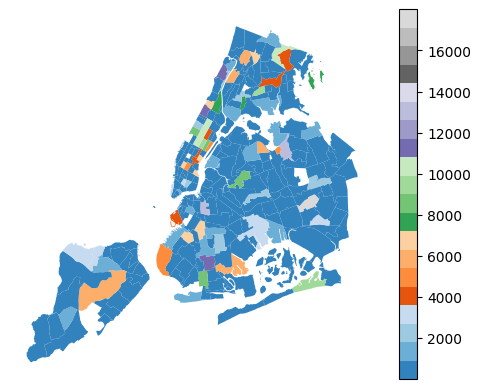

In [28]:
heatmap_for_trips()

### Visualization 5

Create a scatter plot that compares tip amount versus distance. A scatter plot can show us the relationship between tip amount and distance.

In [ ]:
# use a more descriptive name for your function
def tip_amount_vs_distance():
    """Create a scatter plot that compares tip amount versus distance."""
    
    query = '''SELECT tip_amount, distance
            FROM taxi_trips
            '''
    df = pd.read_sql_query(query, engine)
    
    # sample the data to make the scatter plot clearer
    df[(df['distance'] < 100) & (df['tip_amount'] > 0)].sample(800).plot(x="distance", y="tip_amount", kind="scatter", title="Tip Amount vs Distance", xlabel="Distance", ylabel="Tip Amount")

In [ ]:
tip_amount_vs_distance()

### Visualization 6

Create another scatter plot that compares tip amount versus precipitation amount.

In [ ]:
def tip_amount_vs_precipitation():
    """Create another scatter plot that compares tip amount versus precipitation amount."""
    
    query1 ="""SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS DATE, tip_amount
            FROM taxi_trips
            """ 
    query2 ="""SELECT strftime('%Y-%m-%d %H', DATE) AS DATE, HourlyPrecipitation
            FROM hourly_weather
            """

    taxi_data = pd.read_sql_query(query1, engine)
    weather_data = pd.read_sql_query(query2, engine)
    
    taxi_data['DATE'] = pd.to_datetime(taxi_data['DATE'], format='%Y-%m-%d %H')
    weather_data['DATE'] = pd.to_datetime(weather_data['DATE'], format='%Y-%m-%d %H')

    df = pd.merge(taxi_data, weather_data, on='DATE')
    df = df[(df['HourlyPrecipitation'] > 0)]
    
    # sample the data to make the scatter plot clearer
    df.sample(5000).plot(x="HourlyPrecipitation", y="tip_amount", kind="scatter", title="Tip Amount vs Precipitation", xlabel="Precipitation", ylabel="Tip Amount")
    

In [ ]:
tip_amount_vs_precipitation()

## Sunrise and Sunset

Question: What is the total number of trips taken between sunrise and sunset and taken between sunset and sunrise?

We will use a pie chart to show the ratio of trips taken between sunrise and sunset and taken between sunset and sunrise.

In [116]:
def pie_chart_for_sunrise_sunset():
    """Create a pie chart that compares the number of trips that started during the day and night."""
    
    # get the data from the database
    query1 = """WITH hired_trips AS (SELECT date(pickup_datetime) AS DATE, pickup_datetime
               FROM taxi_trips 
               UNION ALL
               SELECT date(pickup_datetime) AS DATE, pickup_datetime FROM uber_trips)
               SELECT date(DATE) AS DATE, pickup_datetime
               FROM hired_trips
               """
    query2 = """SELECT date(DATE) AS DATE, Sunrise, Sunset FROM sun_data"""
    trip_df = pd.read_sql_query(query1, engine)
    sun_df = pd.read_sql_query(query2, engine)
    
    # convert the date to datetime
    trip_df['DATE'] = pd.to_datetime(trip_df['DATE'], format='%Y-%m-%d')
    trip_df['pickup_datetime'] = pd.to_datetime(trip_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    sun_df['DATE'] = pd.to_datetime(sun_df['DATE'], format='%Y-%m-%d')

    # merge the two dataframes
    df = pd.merge(trip_df, sun_df, on='DATE')

    # calculate the minutes using hour and minute
    df['Sunrise_minutes'] = df['Sunrise'].map(lambda x: int(str(x)[0]) * 60 + int(str(x)[1:]))
    df['Sunset_minutes'] = df['Sunset'].map(lambda x: int(str(x)[:2]) * 60 + int(str(x)[2:]))
    df['pickup_datetime_minutes'] = df['pickup_datetime'].map(lambda x: x.hour * 60 + x.minute)

    # find the trips that started during the day
    df['Sun'] = (df['pickup_datetime_minutes'] > df['Sunrise_minutes']) & (df['pickup_datetime_minutes'] < df['Sunset_minutes'])

    # plot the pie chart
    df['Sun'].value_counts().plot(kind='pie', title='Ratio of Day and Night Trips', autopct='%1.1f%%', legend=True, labels=['Day', 'Night'])

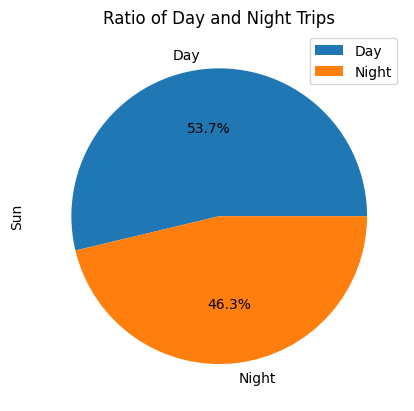

In [117]:
pie_chart_for_sunrise_sunset()

## Matplotlib Animation for Visualization 1

In [ ]:
# read the data
df = pd.read_sql_query(QUERY_1, engine).sort_values(by="time", ascending=True)
df.index = df['time']

def data_gen():
    """Generate data for the plot."""

    for cnt in range(24):
        yield int(df['time'][cnt]), int(df['num'][cnt])

# init the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []

def init():
    """Initialize the plot."""

    ax.set_ylim(0, 14000)
    ax.set_xlim(0, 23)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Trips')
    ax.set_title('Number of Trips for Each Hour of the Day')
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

def run(data: tuple):
    """Update the plot."""

    x, y = data
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, interval=23,
                            repeat=False, init_func=init)
plt.show()

## Unit Tests

We will write unit tests for the functions we defined in the project. Unit tests can help us find bugs in our code.

For visualization functions, we will not write unit tests for them. Because those functions don't return any values, and we can't use assert to check the correctness of the functions.

In [ ]:
import unittest

class TestNotebook(unittest.TestCase):
    """Tests for each function in the notebook."""

    def test_calculate_distance(self):
        """Test the calculate_distance function."""

        from_coord = pd.DataFrame({'pickup_latitude': [40.738353, 40.728225, 40.74077], 'pickup_longitude': [-73.999816, -73.994355, -74.005043]})
        to_coord = pd.DataFrame({'dropoff_latitude': [40.723217, 40.750325, 40.772647], 'dropoff_longitude': [-73.999511, -73.99471, -73.962565]})
        distance = pd.Series([1.683, 2.457, 5.036]) # get the distance from https://www.hhlink.com/%E7%BB%8F%E7%BA%AC%E5%BA%A6

        cal_distance = calculate_distance(from_coord, to_coord)

        assert np.allclose(cal_distance, distance, atol=1e-03) == True
    
    def test_add_distance_column(self):
        """Test the add_distance_column function."""

        df = pd.DataFrame({'pickup_latitude': [40.738353, 40.728225, 40.74077], 'pickup_longitude': [-73.999816, -73.994355, -74.005043], 'dropoff_latitude': [40.723217, 40.750325, 40.772647], 'dropoff_longitude': [-73.999511, -73.99471, -73.962565]})
        df = add_distance_column(df)

        assert df['distance'].isnull().values.any() == False
    
    def test_find_taxi_parquet_urls(self):
        """Test the find_taxi_parquet_urls function."""

        urls = find_taxi_parquet_urls()
        assert len(urls) == 78
        assert urls[0] == 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet'
    
    def test_get_and_clean_month_taxi_data(self):
        """Test the get_and_clean_month_taxi_data function."""

        url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet'
        df = get_and_clean_month_taxi_data(url)

        assert df.shape[0] < 3000
        assert df.notnull().values.any() == True
        assert list(df.columns) == ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'tip_amount']
        assert df.dtypes['pickup_datetime'] == 'datetime64[ns]'
        assert df.dtypes['pickup_longitude'] == 'float32'
        assert df.dtypes['pickup_latitude'] == 'float32'
        assert df.dtypes['dropoff_longitude'] == 'float32'
        assert df.dtypes['dropoff_latitude'] == 'float32'
        assert df.dtypes['tip_amount'] == 'float32'
    
    def test_get_and_clean_taxi_data(self):
        """Test the get_and_clean_taxi_data function."""

        urls = ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-01.parquet','https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2009-01.parquet']
        df = get_and_clean_taxi_data(urls)

        assert df.shape[0] > 4000
        assert df.notnull().values.any() == True
        assert list(df.columns) == ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'tip_amount', 'distance']
        assert df.dtypes['pickup_datetime'] == 'datetime64[ns]'
        assert df.dtypes['pickup_longitude'] == 'float32'
        assert df.dtypes['pickup_latitude'] == 'float32'
        assert df.dtypes['dropoff_longitude'] == 'float32'
        assert df.dtypes['dropoff_latitude'] == 'float32'
        assert df.dtypes['tip_amount'] == 'float32'
        assert df.dtypes['distance'] == 'float32'
    
    def test_load_and_clean_uber_data(self):
        """Test the load_and_clean_uber_data function."""

        df = load_and_clean_uber_data()

        assert df.shape == (195472, 6)
        assert list(df.columns) == ['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance']

    def test_clean_month_weather_data_hourly(self):
        """Test the clean_month_weather_data_hourly function."""

        csv_file = '2009_weather.csv'
        df = clean_month_weather_data_hourly(csv_file)

        assert list(df.columns) == ['DATE', 'HourlyWindSpeed', 'HourlyPrecipitation']
        assert df.dtypes['DATE'] == 'datetime64[ns]'
        assert df.dtypes['HourlyWindSpeed'] == 'float32'
        assert df.dtypes['HourlyPrecipitation'] == 'float32'

    def test_clean_month_weather_data_daily(self):
        """Test the clean_month_weather_data_daily function."""

        csv_file = '2009_weather.csv'
        df, df_sun = clean_month_weather_data_daily(csv_file)

        assert list(df.columns) == ['DATE', 'DailyWindSpeed', 'DailyPrecipitation']
        assert df.dtypes['DATE'] == 'datetime64[ns]'
        assert df.dtypes['DailyWindSpeed'] == 'float32'
        assert df.dtypes['DailyPrecipitation'] == 'float32'
        assert list(df_sun.columns) == ['DATE', 'Sunrise', 'Sunset']
        assert df_sun.dtypes['DATE'] == 'datetime64[ns]'
        assert df_sun.dtypes['Sunset'] == 'int32'
        assert df_sun.dtypes['Sunrise'] == 'int32'

    def test_load_and_clean_weather_data(self):
        """Test the load_and_clean_weather_data function."""

        hourly_data, daily_data, sun_data = load_and_clean_weather_data()

        assert list(hourly_data.columns) == ['DATE', 'HourlyWindSpeed', 'HourlyPrecipitation']
        assert list(daily_data.columns) == ['DATE', 'DailyWindSpeed', 'DailyPrecipitation']
        assert list(sun_data.columns) == ['DATE', 'Sunrise', 'Sunset']

    def test_write_query_to_file(self):
        """Test the write_query_to_file function."""

        import tempfile
        outfile_path = tempfile.mkstemp()[1]

        query = 'SELECT * FROM taxi_data'
        write_query_to_file(query, outfile_path)

        with open(outfile_path, 'r') as f:
            query = f.read()
        assert query == 'SELECT * FROM taxi_data'



In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)